In [31]:
import matplotlib.pyplot as plt
import skimage.io, skimage.color
import scipy, scipy.signal, scipy.ndimage
from PIL import Image
import numpy as np
import IPython.display
from io import BytesIO

In [115]:
def show_gif(a, width="100%", duration=10, file=None):
    a = np.array(a)[...,:3]
    
    
    
    frames = []
    for frame in range(a.shape[0]):
        img = PIL.Image.fromarray(a[frame, ...])
        frames.append(img)
    if file is None:
        f = BytesIO()
        img.save(
            f, format="png", save_all=True, append_images=frames, loop=0, duration=duration
        )
        IPython.display.display(IPython.display.Image(data=f.getvalue(), width=width))
    else:
        with open(file, "wb") as f:
            img.save(
                f, format="png", save_all=True, append_images=frames, loop=0, duration=duration
            )        

In [13]:
## Parallax example

imgs = ["parallax-mountain-bg.png",
"parallax-mountain-foreground-trees.png",
"parallax-mountain-montain-far.png",
"parallax-mountain-mountains.png",
"parallax-mountain-trees.png"]

layers = {img: skimage.io.imread("parallax_mountain_pack/" + img) for img in imgs}



In [117]:

def hscroll(layer, x):
    x = x % layer.shape[1]    
    return np.concatenate([layer[:, -x:], layer[:, :-x]], axis=1)

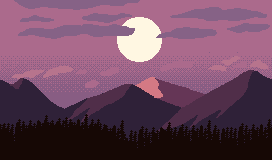

In [131]:
def crop(img, r, c):
    img = img[:r, :c, :]
    if img.shape[2] == 3:
        v = np.full((r, c, 4), 255)
        v[..., :3] = img[:r, :c, :3]
        return v
    else:
        return img[:r, :c, :]
    

def parascroll(layers, layer_rates, size, n_frames = 10):
    w, h = size
    frames = []
    offsets = np.zeros(len(layer_rates))
    layer_rates = np.array(layer_rates)
    for i in range(n_frames):        
        blend = np.zeros((h, w, 4), np.uint8)
        offsets += layer_rates
        for layer_index, layer in enumerate(layers):
            x_offset = int(offsets[layer_index])
            frame = hscroll(layers[layer], x_offset)            
            img = crop(frame, 160, 272)            
            alpha = img[...,3]/255.0
            blend = ((blend.T * (1-alpha.T)) + (img.T * alpha.T)).T
            blend = blend.astype(np.uint8)
        frames.append(blend)
    
    return frames

anim = parascroll(layers, [0.1,0.3,0.8,1.6,3.2], (272, 160), 40)            
show_gif(anim, width="10%")
show_gif(anim, file="parallax.png")



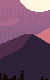

In [132]:
show_gif(np.array(anim)[:,50:130, 100:150,:], width="10%")
show_gif(np.array(anim)[:,50:130, 100:150,:], width="10%", file="parallax_closeup.png")

In [140]:
def hscroll_subpixel(img, x_fraction, interpolator):
    img_i = interpolator(img)
    r, c = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))
    
    shifted = np.zeros_like(img)    
    for i, j in zip(r.ravel(), c.ravel()):
        shifted[i,j] = img_i(i, j+x_fraction)
    return shifted


In [149]:
def make_bilinear_interpolator(img):    
    def interpolate(x,y):        
        # get fractional coordinates
        yi, yf = int(np.floor(y)), y-np.floor(y)
        xi, xf = int(np.floor(x)), x-np.floor(x)
        # factorised into three equivalent interpolations here 
        # A----B
        # |    |
        # |    |
        # C----D
        #
        # A-top-B
        #    |
        #   ctr
        #    |
        # C-bot-D
        xi = min(xi, img.shape[0]-2)
        yi = min(yi, img.shape[1]-2)
        A, B = img[xi, yi], img[xi+1, yi]
        C, D = img[xi, yi+1], img[xi+1, yi+1]
        top = A * (1-xf) + B * xf
        bot = C * (1-xf) + D * xf
        ctr = top * (1-yf) + bot * yf
        return ctr        
        
    return interpolate

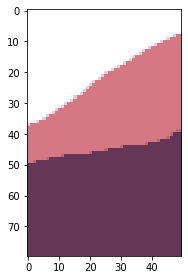

In [158]:
skimage.io.imshow(hscroll_subpixel(layers[list(layers.keys())[2]][80:, 50:100], 0.25, make_bilinear_interpolator))

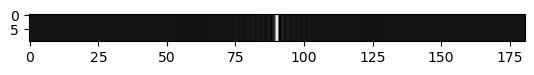

In [167]:
## Create subpixel 1D convolution table 
## Using sinc interpolation
## at a given resolution
## (since they are separable, we just need 1D tables)

def make_subpixel(offset, n):
    x = np.arange(-n, n+1)
    s = np.sinc(x+offset) * scipy.signal.hann(len(x))
    return s / np.sum(s)



# the same but using a Gaussian instead of sinc
def make_subpixel_gauss(offset, n):
    x = np.arange(-n, n+1)
    v = 0.4
    s = 1/(2*np.pi*v)**0.5 * np.exp(-(x-offset)**2/(2*v**2)) 
    return s / np.sum(s)

    


pix = make_subpixel(0.1, 90)
plt.imshow(np.tile(pix, (10,1)), cmap="gray")


In [172]:

## Create a full table of subpixel convolutions
def make_subpixel_table(n, width):
    return [make_subpixel_gauss(i/n, width) for i in range(n)]
    
table = make_subpixel_table(64, 8)


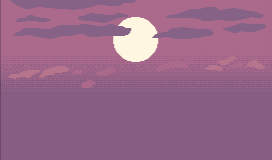

In [175]:
from IPython.display import display
from IPython.display import Image as PIMage

def convolve_subpixel(img, table, x_fraction):
    x_fraction = x_fraction % 1
    x_offset = int(x_fraction * len(table))
    x_fraction = x_fraction * len(table)- x_offset
    img = img/255.0    
    # repeat convolution for all channels    
    return np.stack([scipy.signal.convolve2d(img[...,i], table[x_offset].reshape(1,-1), mode="same") for i in range(img.shape[2])], axis=2)

    
l = list(layers.keys())[0]
# convert numpy array to Image 
# (to display with Ipython.display)
def to_img(img):
    img = Image.fromarray(np.maximum(img*255,0).astype(np.uint8))
    f = BytesIO()
    img.save(
            f, format="png"
        )
            
    return PIMage(data=f.getvalue(), format="png")


display(to_img(convolve_subpixel(layers[l].astype(np.float64), table, 0.3)))

In [26]:
skimage.io.find_available_plugins()

{'fits': ['imread', 'imread_collection'],
 'gdal': ['imread', 'imread_collection'],
 'gtk': ['imshow'],
 'imageio': ['imread', 'imsave', 'imread_collection'],
 'imread': ['imread', 'imsave', 'imread_collection'],
 'matplotlib': ['imshow', 'imread', 'imshow_collection', 'imread_collection'],
 'pil': ['imread', 'imsave', 'imread_collection'],
 'qt': ['imshow', 'imsave', 'imread', 'imread_collection'],
 'simpleitk': ['imread', 'imsave', 'imread_collection'],
 'tifffile': ['imread', 'imsave', 'imread_collection']}